C221011김수민

## 이원분산분석

주효과와 교호작용효과
- 주효과: 각 요인이 독립적으로 특성치에 미치는 영향
- 교호작용효과: 두 요인의 조합이 특성치에 미치는 영향
    - 교호작용효과가 유의하다면, 요인 A의 수준에 다른 특성치의 변화가 요인 B의 수준에 따라 달라짐
    - 교호작용효과가 유의하다면, 주효과의 해석이 의미가 없어지므로 주효과 분석은 하지 않음

반복이 없는 이원분산분석과 반복이 있는 이원분산분석
- 반복이 없는 이원분산분석: 각 수준의 조합에 대한 측정값이 한 번만 측정된 경우
    - 교호작용효과를 잔차로 풀링하여 분석
    - 교호작용효과를 분석할 수 없음
- 반복이 있는 이원분산분석: 각 수준 조합에 대한 측정값이 적어도 한 조합에는 두 번 이상 측정된 경우
    - 교호작용효과를 분석할 수 있음


검정 시 교호작용을 먼저 체크하고 유의하다면 주효과 검정을 진행하지 않고 사후분석을 진행한다. 유의하지 않다면 각 요소의 주효과를 검정한 후 유의한 요소만 사후분석을 한다.

In [28]:
import pandas as pd
df=pd.DataFrame({
    'drug':['A']*6+['B']*6,
    #반복이 있는 이원분산분석
    'dosage':[100,100,150,150,200,200]*2,
    'BP':[184,168,160,145,192,176,143,167,135,123,140,152]
})
df['treatment']=df['drug']+'-'+df['dosage'].astype(str)
df

,drug,dosage,BP,treatment
0,A,100,184,A-100
1,A,100,168,A-100
2,A,150,160,A-150
3,A,150,145,A-150
4,A,200,192,A-200
5,A,200,176,A-200
6,B,100,143,B-100
7,B,100,167,B-100
8,B,150,135,B-150
9,B,150,123,B-150


longform인 데이터로 tidy data이다.

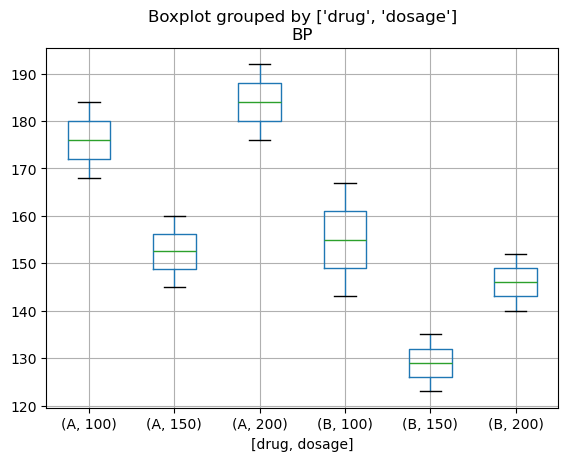

In [29]:
df.boxplot(by=['drug','dosage']);

가정확인
- 정규성 검정은 편의상 전체 데이터를 사용하여 수행

통계량:0.9771,p-value:0.9692
정규분포를 따름


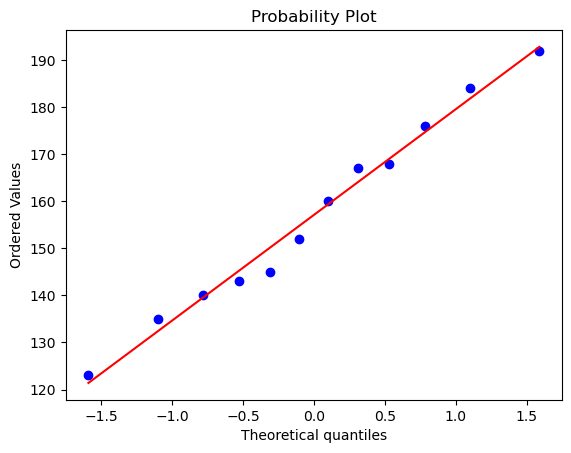

In [30]:
import scipy.stats as stats
import matplotlib.pyplot as plt
stat,p_value=stats.shapiro(df.BP)
print(f'통계량:{stat:.4f},p-value:{p_value:.4f}')
if p_value<0.05:
    print('정규분포를 따르지 않음')
else:
    print('정규분포를 따름')
stats.probplot(df.BP,dist='norm',plot=plt)
plt.show()

등분산성 검정

In [31]:
stat,p_value=stats.levene(df.BP[df.drug=='A'],df.BP[df.drug=='B'])
print(f'통계량:{stat:.4f}, p_value:{p_value:.4f}')
if p_value<0.05:
    print('모든 그룹의 분산이 같지 않음')
else:
    print('모든 그룹의 분산이 같음')

통계량:0.2141, p_value:0.6535
모든 그룹의 분산이 같음


ANOVA Table 작성


In [32]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula='BP~C(drug)+C(dosage)+C(drug):C(dosage)'
model=ols(formula,df).fit()
result=anova_lm(model)
print(result)

                    df       sum_sq      mean_sq          F    PR(>F)
C(drug)            1.0  2268.750000  2268.750000  17.004997  0.006190
C(dosage)          2.0  1601.166667   800.583333   6.000625  0.037029
C(drug):C(dosage)  2.0   168.500000    84.250000   0.631480  0.563784
Residual           6.0   800.500000   133.416667        NaN       NaN


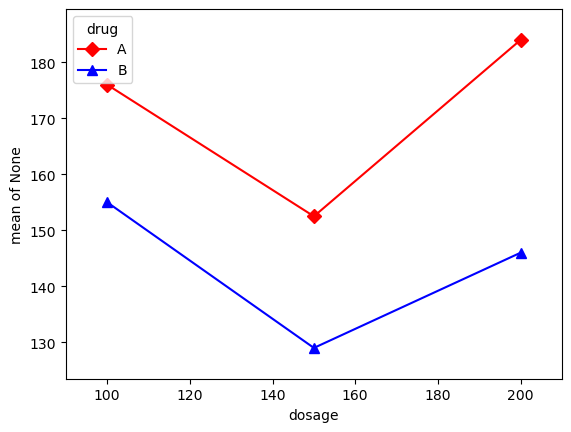

In [33]:
#교호작용 그래프 그리기
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig= interaction_plot(
    x=df['dosage'],
    trace=df['drug'],#교호작용을 볼 변수
    response=model.fittedvalues, #y축 변수, 예측값
    colors=['red','blue'],
    markers=['D','^'],
    ms=7

)

두 그래프가 거의 평행하기 때문에 교호작용이 유의하지 않다는 결과 예상 가능      
교호작용이 유의하지 않다고 나왔으므로 drug과 dosage의 주효과를 확인해봐야 한다.     
교호작용이 유의하지 않으므로 polling한다.(formula='BP~C(drug)+C(dosage)+C(drug):C(dosage)'에서 교호작용 항목을 제외한다)

In [34]:
formula='BP~C(drug)+C(dosage)'
model=ols(formula,df).fit()
result=anova_lm(model)
print(result)

            df       sum_sq      mean_sq          F    PR(>F)
C(drug)    1.0  2268.750000  2268.750000  18.730650  0.002519
C(dosage)  2.0  1601.166667   800.583333   6.609563  0.020205
Residual   8.0   969.000000   121.125000        NaN       NaN


두 요인이 모두 유의수준인 0.05보다 작은 p-value를 가지므로 주효과가 유의하다.   
고혈압약의 종류에 따라 수축기 혈압은 평균과 다르다.   
처방 용량에 따라 수축기 혈압의 평균은 다르다.   

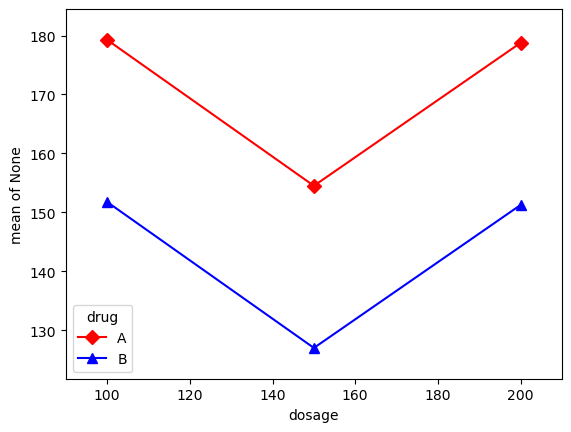

In [35]:
fig= interaction_plot(
    x=df['dosage'],
    trace=df['drug'],#교호작용을 볼 변수
    response=model.fittedvalues, #y축 변수, 예측값
    colors=['red','blue'],
    markers=['D','^'],
    ms=7

)

교호작용 요소를 없앴기에 완전히 평행하게 나온다

사후검정
- 교호작용효과는 유의하지 않으므로 원래는 사후검정을 수행하지 않으나, 예시를 위해 수행

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper  reject
------------------------------------------------------
 A-100  A-150    -23.5 0.4196  -69.4697 22.4697  False
 A-100  A-200      8.0 0.9762  -37.9697 53.9697  False
 A-100  B-100    -21.0 0.5174  -66.9697 24.9697  False
 A-100  B-150    -47.0 0.0455  -92.9697 -1.0303   True
 A-100  B-200    -30.0   0.23  -75.9697 15.9697  False
 A-150  A-200     31.5  0.199  -14.4697 77.4697  False
 A-150  B-100      2.5 0.9999  -43.4697 48.4697  False
 A-150  B-150    -23.5 0.4196  -69.4697 22.4697  False
 A-150  B-200     -6.5 0.9902  -52.4697 39.4697  False
 A-200  B-100    -29.0 0.2531  -74.9697 16.9697  False
 A-200  B-150    -55.0 0.0226 -100.9697 -9.0303   True
 A-200  B-200    -38.0  0.106  -83.9697  7.9697  False
 B-100  B-150    -26.0 0.3353  -71.9697 19.9697  False
 B-100  B-200     -9.0 0.9616  -54.9697 36.9697  False
 B-150  B-200     17.0 0.6917  -28.9697 62.9697  False
----------

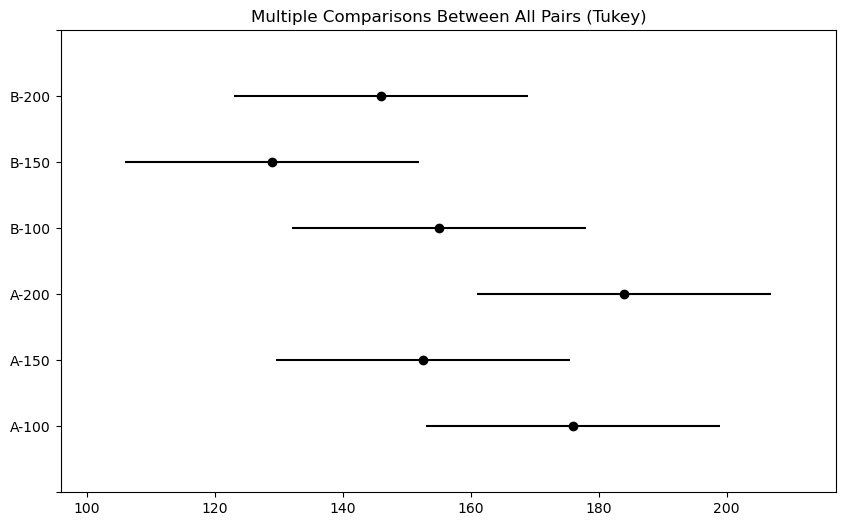

In [36]:
from statsmodels.stats.multicomp import MultiComparison

posthoc= MultiComparison(
    data=df['BP'],
    groups=df['treatment']
)

result=posthoc.tukeyhsd(alpha=0.05)

print(result.summary())
result.plot_simultaneous();

 A-100  B-150,  A-200  B-150 일 때  유의하다.(차이가 있다)

요인1 주효과에 대한 사후검정 실행

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    -27.5 0.014 -48.1235 -6.8765   True
----------------------------------------------------


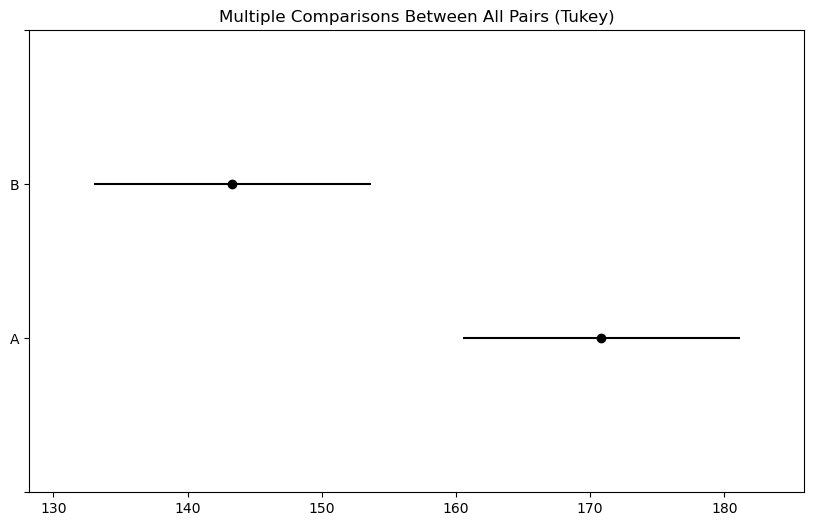

In [37]:
posthoc= MultiComparison(
    data=df['BP'],
    groups=df['drug']
)

result=posthoc.tukeyhsd(alpha=0.05)

print(result.summary())
result.plot_simultaneous();

종류 A와 B 간에 차이가 있다

요인2 주효과에 대한 사후검정 실행

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   100    150   -24.75 0.2099 -62.1957 12.6957  False
   100    200     -0.5 0.9992 -37.9457 36.9457  False
   150    200    24.25 0.2213 -13.1957 61.6957  False
-----------------------------------------------------


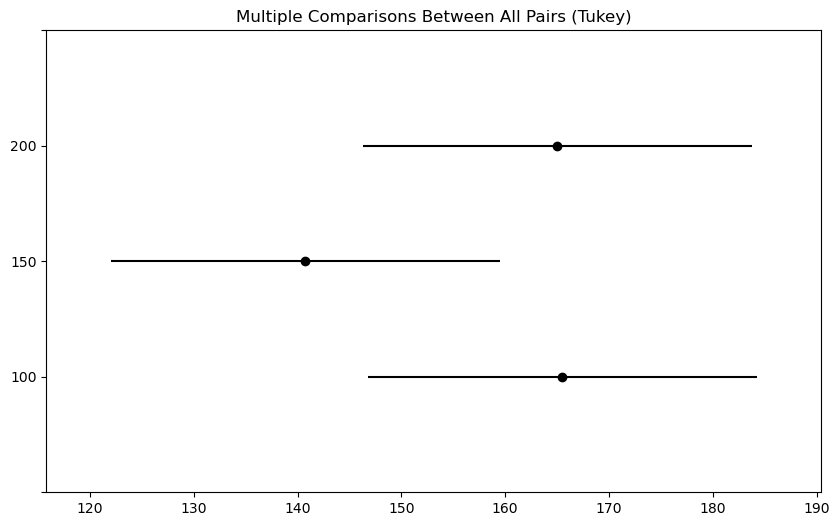

In [38]:
posthoc= MultiComparison(
    data=df['BP'],
    groups=df['dosage']
)

result=posthoc.tukeyhsd(alpha=0.05)

print(result.summary())
result.plot_simultaneous();

실질적으로는 각 수준 간 차이가 없다.